In [4]:
!nvidia-smi

Thu Feb  6 17:40:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:03:00.0 Off |                  N/A |
| 55%   63C    P2   191W / 200W |  11039MiB / 11178MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:04:00.0  On |                  N/A |
| 51%   61C    P2   185W / 200W |   7599MiB / 11175MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [5]:
# Compatible with tensorflow backend
import tensorflow as tf
import keras.backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *

In [6]:
x = list(reversed( [[1,2,3],[2,3,4]]))
x

[[2, 3, 4], [1, 2, 3]]

In [4]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True
session = tf.Session(config=tf_config)
K.set_session(session)

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [5]:
import pandas as pd
# df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')
df = pd.read_csv ('../train.csv')

In [26]:
# label_tag = (list(set (df.label)))
# label_tag.sort()
# cutdata = []
# for i in range (len(label_tag)):
#     df_go = df[df.label == label_tag[i]].head(350000)
#     cutdata.append(df_go)

In [27]:
# df = pd.concat(cutdata, axis = 0)

Text(0.5, 0, 'Label')

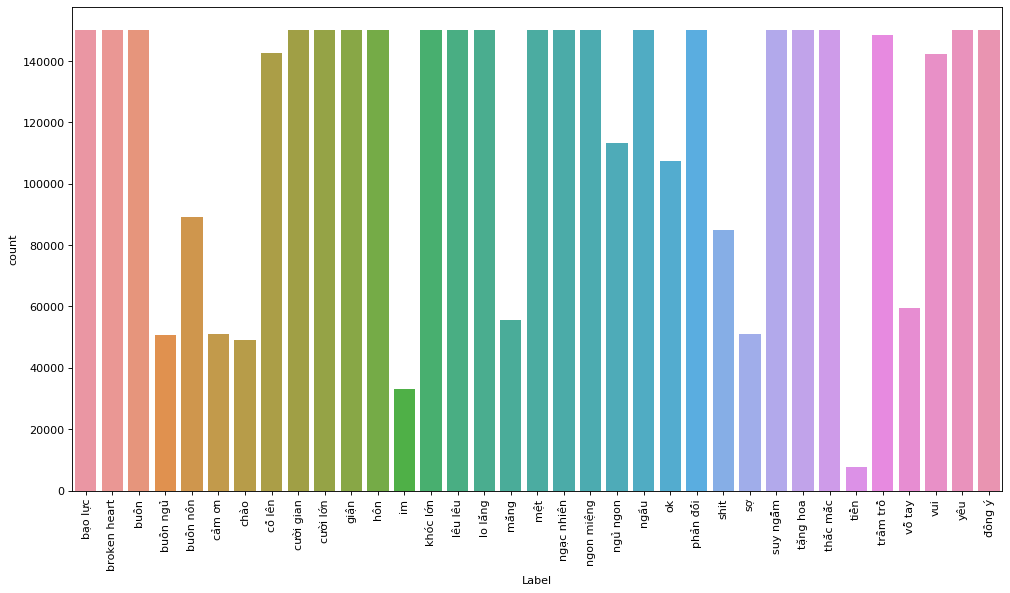

In [6]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.target)
plt.xlabel('Label')

In [7]:
X = df.status
Y = df.target
le = LabelEncoder()
Y = le.fit_transform(Y)

In [8]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [9]:
Y = np.array(onehot_Y)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=11)

In [11]:
max_len = 30
max_words = 88860
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)

max_words = len(tok.index_word)+1

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [12]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [13]:
word_dict = pickle.load (open("../word_embedding_vec.pkl",'rb'))

In [14]:
w = np.random.normal(0, 1, (max_words, 300))

In [15]:
for i in range (1, max_words):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [16]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(tf.reverse(inputs,[0]))
    layer = LSTM(128, return_sequences= True)(layer)
    layer = LSTM(128, return_sequences= True)(layer)
    layer = LSTM(128, return_sequences= True )(layer)
    layer = GlobalMaxPooling1D()(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

# def RNN():
#     inputs = Input(name = 'inputs', shape =[max_len])
#     layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
#     layer = Bidirectional(LSTM(128, return_sequences = True))(layer)
#     layer = Bidirectional(LSTM(128))(layer)
#     layer = Dense(256, name = "FC1")(layer)
#     layer = Activation('relu')(layer)
#     layer = Dropout(0.5)(layer)
#     layer = Dense(35, name = 'out_layer')(layer)
#     layer = Activation('softmax')(layer)
    
#     model = Model (inputs = inputs, outputs = layer)
#     return model
    

In [7]:
arr = [[1,2,3],[4,5,6],[7,8,9,]]
tf.reverse(arr, [0])

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]], dtype=int32)>

In [17]:
# from tensorflow.python.compiler.tensorrt import trt_convert as trt

model  = RNN()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
tf_op_layer_ReverseV2 (Tenso [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           35031900  
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0     

In [18]:

# def focal_loss(gamma=10, alpha=.25):
def focal_loss(gamma=10, alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

# focal loss
# model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')

In [20]:
weight_file = "model_LSTM_w17_Test.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [22]:
history = model.fit(sequences_matrix,Y_train,batch_size = 2048, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

Train on 2678984 samples, validate on 669747 samples
Epoch 1/10
2678784/2678984 [============================>.] - ETA: 0s - loss: 3.4705 - accuracy: 0.0358
Epoch 00001: val_loss improved from inf to 3.46855, saving model to model_LSTM_w17_Test.hdf5
2678984/2678984 [==============================] - 437s 163us/sample - loss: 3.4705 - accuracy: 0.0358 - val_loss: 3.4685 - val_accuracy: 0.0360
Epoch 2/10
2678784/2678984 [============================>.] - ETA: 0s - loss: 3.4688 - accuracy: 0.0359
Epoch 00002: val_loss improved from 3.46855 to 3.46763, saving model to model_LSTM_w17_Test.hdf5
2678984/2678984 [==============================] - 439s 164us/sample - loss: 3.4688 - accuracy: 0.0359 - val_loss: 3.4676 - val_accuracy: 0.0354
Epoch 3/10
2678784/2678984 [============================>.] - ETA: 0s - loss: 3.4685 - accuracy: 0.0357
Epoch 00003: val_loss did not improve from 3.46763
2678984/2678984 [==============================] - 447s 167us/sample - loss: 3.4685 - accuracy: 0.0357 -

In [23]:
X_test = [str(s) for s in X_test]
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

837183/837183 [==============================] - 207s 248us/sample - loss: 3.4675 - accuracy: 0.0358


In [51]:
preds = model.predict(test_sequences_matrix, batch_size=2048)

In [52]:
f1_score(Y_test.argmax(1), preds.argmax(1), average='macro')

0.00202543101797565

In [53]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 3.468
  Accuracy: 0.036
